In [1]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=718bc6e6585b4f634cf5f6811c0985b990d2028f2aa8f38054915eef4fa8e25a
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
!pip install torchviz # module to plot the model architecture

In [ ]:
pip install numpy pandas scikit-learn

In [2]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers, gradient descent, ADAM optimizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from pyDOE import lhs
import numpy as np
import time
from scipy.interpolate import interp1d
from IPython import display

In [3]:
# Loading the Dataset
df = pd.read_csv('wave-7dayopdata.csv')

# Converting DateTime to a numerical format
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['timestamp'] = (df['DateTime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Calculating the time since the start in seconds
df['time_since_start'] = (df['DateTime'] - df['DateTime'].iloc[0]).dt.total_seconds()

# Create scalers
scaler_lat_long = MinMaxScaler(feature_range=(-1, 1))
scaler_wave_height = MinMaxScaler(feature_range=(0, 1))  # Assuming wave height should be positive

# For spatial data
scaler_lat_long.fit(df[['Latitude', 'Longitude']])
# For wave height
scaler_wave_height.fit(df[['SignificantWaveHeight']])

# Transforming the data using the fitted scalers
df[['Latitude', 'Longitude']] = scaler_lat_long.transform(df[['Latitude', 'Longitude']])
df['SignificantWaveHeight'] = scaler_wave_height.transform(df[['SignificantWaveHeight']])

# Selecting the rows that correspond to the initial condition
IC_X = df.loc[df['time_since_start'] == 0, ['Latitude', 'Longitude']].values
# Adding a third column for time, which should be zeros since it's the initial condition
IC_X = np.hstack((IC_X, np.zeros((IC_X.shape[0], 1))))

# IC_Y, which is just the SignificantWaveHeight at the initial condition
IC_Y = df.loc[df['time_since_start'] == 0, 'SignificantWaveHeight'].values.reshape(-1, 1)

#print("IC_X:", IC_X)
#print("IC_Y:", IC_Y)

In [4]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)
#PyTorch random number generator
torch.manual_seed(1234)
# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda


In [5]:
# '''Training parameters'''
steps=10000 # step
lr=1e-4 # learning rate
layers = np.array([2,128,256,128,1]) # input x and t, outputs p

#Nu: Number of training points
N_u = 100 #Total number of data points for 'u'
# Nf: Number of collocation points (Evaluate PDE)
N_f = 1000 #Total number of collocation points

# Domain mesh
L_x = 1   # Range of the domain according to x [m]
dx = 0.01 # Mesh size
N_x = int(L_x/dx) # Points number of the spatial mesh
X = np.linspace(-L_x,L_x,N_x+1) # Spatial array

# Time step mesh
L_t = 0.2 #Duration of simulation [s]
dt = 0.2*dx  #Infinitesimal time with CFL (Courant–Friedrichs–Lewy condition)
N_t = int(L_t/dt) #Points number of the temporal mesh
T = np.linspace(0,L_t,N_t+1) #Temporal array

x0 = 0.0 # Source position
sigma = 0.05 # Source width

In [6]:
def plot3D(x,t,y):
    X,T= np.meshgrid(x,t)
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="ocean")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T, X, F_xt,cmap="ocean")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()

def plot3D_Train(x,t,y,step,loss):
    X,T= x,t
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="ocean")
    fig.colorbar(cp)
    ax.set_title("step: {},loss: {:.2f}".format(step, loss) )
    ax.set_xlabel('t')
    ax.set_ylabel('x')

def plot3D_Matrix(x,t,y):
    X,T= x,t
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="ocean")
    fig.colorbar(cp)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="ocean")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()

In [7]:
#Customize activation function
class SinActivation(nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        return
    def forward(self, x):
        return torch.sin(x)

In [9]:
# Fully Connected Neural Network Layer for the PINN model Architecture
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class
        # activation function
        self.activation = SinActivation()
        # loss function
        self.loss_function = nn.MSELoss(reduction ='mean')
        # Initializing neural network as a list using nn.Modulelist
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        #Xavier Normal Initialization for the neural networks
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    # foward pass
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
         # preprocessing input
        x = (x - l_b)/(u_b - l_b) #feature scaling
        # convert to float
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    # Initial condition loss
    def loss_IC(self,X_IC,y):
        loss_I = self.loss_function(self.forward(X_IC), y)
        return loss_I

    # Boundary condition loss
    def loss_BC(self,X_BC):
        g = X_BC.clone()
        g.requires_grad = True
        p = self.forward(g)
        p_x_t = autograd.grad(p,g,torch.ones([X_BC.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        p_x = p_x_t[:,[0]] # dp/dx = 0
        loss_BC = self.loss_function(p_x,p_x_hat) # dp/dx = 0
        return loss_BC

    'PDE loss'
    def loss_PDE(self, X_PDE):
        g = X_PDE.clone()
        g.requires_grad = True
        p = self.forward(g)
        p_x_t = autograd.grad(p,g,torch.ones([X_PDE.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        p_xx_tt = autograd.grad(p_x_t,g,torch.ones(X_PDE.shape).to(device), create_graph=True)[0]
        p_x = p_x_t[:,[0]]
        p_t = p_x_t[:,[1]]
        p_xx = p_xx_tt[:,[0]]
        p_tt = p_xx_tt[:,[1]]
        c = 1.0
        f = p_tt - c**2*p_xx
        loss_f = self.loss_function(f,f_hat)
        return loss_f

    def loss(self,X_BC,X_IC,y,X_PDE):
        loss_IC = self.loss_IC(X_IC,y)
        loss_BC = self.loss_BC(X_BC)
        loss_f = self.loss_PDE(X_PDE)
        loss_val = 100*loss_IC + loss_BC +10*loss_f
        #loss_val = loss_IC/loss_IC.detach() + loss_BC/loss_BC.detach() + loss_f/loss_f.detach()
        return loss_val

    'test neural network'
    def test(self):
        u_pred = self.forward(X)
        # Relative L2 Norm of the error (Vector)
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)
        return error_vec

In [10]:
# MODULES IMPORTATION
# Def of the initial condition
def I(x):

    #Single space variable function that
    #represent the wave form at t = 0
    return np.exp(-(x-x0)**2/sigma)

# SETTING-UP THE PROBLEM
# Medium velocity
# Def of velocity (spatial scalar field)
def celer(x):
    # velocity is constant
    return 1


left_bound_cond = 1  #Boundary cond 1 : Dirichlet, 2 : Neumann
right_bound_cond = 1  #Boundary cond 1 : Dirichlet, 2 : Neumann

# Temporal mesh with CFL < 1 - j indices
# Velocity array for calculation (finite elements)
c = np.zeros(N_x+1, float)
for i in range(0,N_x+1):
    c[i] = celer(X[i])

# CALCULATION CONSTANTS
c_1 = c[0]
c_2 = c[N_x]

C2 = (c_1*dt/dx)**2

CFL_1 = c_1*(dt/dx)
CFL_2 = c_2*(dt/dx)

#PROCESSING LOOP
u_jm1 = np.zeros(N_x+1,float)   #Vector array u_i^{j-1}
u_j = np.zeros(N_x+1,float)     #Vector array u_i^j
u_jp1 = np.zeros(N_x+1,float)   #Vector array u_i^{j+1}

q = np.zeros(N_x+1,float)
q[0:N_x+1] = c[0:N_x+1]**2

U = np.zeros((N_x+1,N_t+1),float) #Global solution

#init cond - at t = 0
u_j[0:N_x+1] = I(X[0:N_x+1])
U[:,0] = u_j.copy()

#init cond - at t = 1
#without boundary cond
u_jp1[1:N_x] =  u_j[1:N_x] + 0.5*C2*( 0.5*(q[1:N_x] + q[2:N_x+1])*(u_j[2:N_x+1] - u_j[1:N_x]) - 0.5*(q[0:N_x-1] + q[1:N_x])*(u_j[1:N_x] - u_j[0:N_x-1]))

#left boundary conditions
if left_bound_cond == 1:
    #Dirichlet bound cond
    u_jp1[0] = 0
else:
    #Nuemann bound cond
    #i = 0
    u_jp1[0] = u_j[0] + 0.5*C2*( 0.5*(q[0] + q[0+1])*(u_j[0+1] - u_j[0]) - 0.5*(q[0] + q[0+1])*(u_j[0] - u_j[0+1]))

#right boundary conditions
if right_bound_cond == 1:
    #Dirichlet bound cond
    u_jp1[N_x] = 0
else:
    #Nuemann bound cond
    #i = N_x
    u_jp1[N_x] =  u_j[N_x] + 0.5*C2*( 0.5*(q[N_x-1] + q[N_x])*(u_j[N_x-1] - u_j[N_x]) - 0.5*(q[N_x-1] + q[N_x])*(u_j[N_x] - u_j[i-1]))

u_jm1 = u_j.copy()  #go to the next step
u_j = u_jp1.copy()  #go to the next step
U[:,1] = u_j.copy()


#Process loop (on time mesh)
for j in range(1, N_t):
    #calculation at step j+1
    #without boundary cond
    u_jp1[1:N_x] = -u_jm1[1:N_x] + 2*u_j[1:N_x] + C2*( 0.5*(q[1:N_x] + q[2:N_x+1])*(u_j[2:N_x+1] - u_j[1:N_x]) - 0.5*(q[0:N_x-1] + q[1:N_x])*(u_j[1:N_x] - u_j[0:N_x-1]))

    #left bound conditions
    if left_bound_cond == 1:
        #Dirichlet bound cond
        u_jp1[0] = 0
    else:
        #Nuemann bound cond
        #i = 0
        u_jp1[0] = -u_jm1[0] + 2*u_j[0] + C2*( 0.5*(q[0] + q[0+1])*(u_j[0+1] - u_j[0]) - 0.5*(q[0] + q[0+1])*(u_j[0] - u_j[0+1]))

    #right bound conditions
    if right_bound_cond == 1:
        #Dirichlet bound cond
        u_jp1[N_x] = 0
    else:
        #Nuemann bound cond
        #i = N_x
        u_jp1[N_x] = -u_jm1[N_x] + 2*u_j[N_x] + C2*( 0.5*(q[N_x-1] + q[N_x])*(u_j[N_x-1] - u_j[N_x]) - 0.5*(q[N_x-1] + q[N_x])*(u_j[N_x] - u_j[N_x-1]))

    u_jm1[:] = u_j.copy()   #go to the next step
    u_j[:] = u_jp1.copy()   #go to the next step
    U[:,j] = u_j.copy()

u_FDTD = U.transpose()
x_FDTD = X
t_FDTD = T
nt = N_t

In [11]:
X, T = np.meshgrid(x_FDTD,t_FDTD)
X_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
Y_test = u_FDTD.flatten()[:,None]

In [13]:
# Fetching some space-time points and corresponding pressure as measurements
# Measurements number
M = 100
Choice = np.random.choice(X_test.shape[0],M,replace = 'False')

Measure_X = X_test[Choice,:]
Measure_Y = Y_test[Choice,:]

In [15]:
# Preprocessing the Dataset to create a tensor for inputting into the Network
df_initial = df[df['time_since_start'] == 0]
x_data = df_initial['Longitude'].values
y_data = df_initial['SignificantWaveHeight'].values

# Creating an interpolation function
interp_func = interp1d(x_data, y_data, kind='cubic', fill_value='extrapolate')
losses_PINN_realworld = []
losses_PINN_synthetic = []

# Use the interpolation function to create IC_Y values at the x_FDTD points
IC_Y = interp_func(x_FDTD).reshape(-1, 1)
#print(IC_Y)

In [16]:
# Domain bounds
lb = X_test[0]  # [-1. 0.] x_bound = -1 ~ 1
ub = X_test[-1] # [1.  4.] t = 0 ~ 4
print(lb,ub)

# Storing the Loss for plotting later
losses_PINN_realworld = []
losses_PINN_synthetic = []


# Initial conditions and measurements
#Initial Condition -1 =< x =<1 and t = 0
IC_X = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1

# Commenting out the use of Synthetic Data
#IC_Y = np.exp(-((x_FDTD-x0)**2)/sigma)[:,None]

# Preprocessing the Dataset to create a tensor for inputting into the Network
df_initial = df[df['time_since_start'] == 0]
x_data = df_initial['Longitude'].values
y_data = df_initial['SignificantWaveHeight'].values
# Creating an interpolation function based on your dataset
interp_func = interp1d(x_data, y_data, kind='cubic', fill_value='extrapolate')
# Using the interpolation function to create IC_Y values at the x_FDTD points
IC_Y = interp_func(x_FDTD).reshape(-1, 1)

#choose random N_u points for training
# idx = np.random.choice(X_train.shape[0], N_u, replace=False)

# If we have measurement data
if Measure_X.shape[0] > 1:
    X_train_Ini = np.vstack((IC_X,Measure_X))
    Y_train_Ini = np.vstack((IC_Y,Measure_Y))
else:
    X_train_Ini = IC_X
    Y_train_Ini = IC_Y

# Boundary Conditions
#Boundary Condition x = -1 and 0 =<t=<1, dp/dx=0
bottom_X = np.hstack((X[:,0][:,None], T[:,0][:,None]))
#Boundary Condition x = 1 and 0 =<t=<1, dp/dx=0
top_X = np.hstack((X[:,-1][:,None], T[:,0][:,None]))

#choose random N_u points for training
# idx = np.random.choice(bottom_X.shape[0], N_u, replace=False)

X_train_Bound = np.vstack((bottom_X,top_X))

# Collocation Points
# Latin Hypercube sampling for collocation points
# N_f sets of tuples(x,t)
X_train_Nf = lb + (ub-lb)*lhs(2,N_f)
# X_train_Nf = np.vstack((X_train_Nf, X_train_Nu)) # append training points to collocation points

[-1.  0.] [1.  0.2]


In [17]:
# Instantiate the model
PINN = FCN(layers)
PINN.to(device)

# Print the model architecture
print(PINN)


FCN(
  (activation): SinActivation()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [ ]:
# No need to execute this block of code unless required to see model architecture
from torchviz import make_dot
# Professor pip install torchviz to run the code to create the model architecture image
# To print the model architecutre
dummy_input = torch.randn(1, layers[0]).to(device)
# Get the output from the model using the dummy input
y_dummy = PINN(dummy_input)
# Generate the graph
dot = make_dot(y_dummy, params=dict(list(PINN.named_parameters()) + [('input', dummy_input)]))
# Save the graph to a file or render it in a Jupyter notebook
dot.render('model_architecture', format='png')


'model_architecture.png'

In [18]:
print("X_train_Bound shape:", X_train_Bound.shape)
print("X_train_Ini shape:", X_train_Ini.shape)
print("Y_train_Ini shape:", Y_train_Ini.shape)
print("X_train_Nf shape:", X_train_Nf.shape)

X_train_Bound shape: (202, 2)
X_train_Ini shape: (201, 2)
Y_train_Ini shape: (201, 1)
X_train_Nf shape: (1000, 2)


In [19]:
# Incase to check the Preprocessed Values
#print(IC_X)
#print(IC_Y)

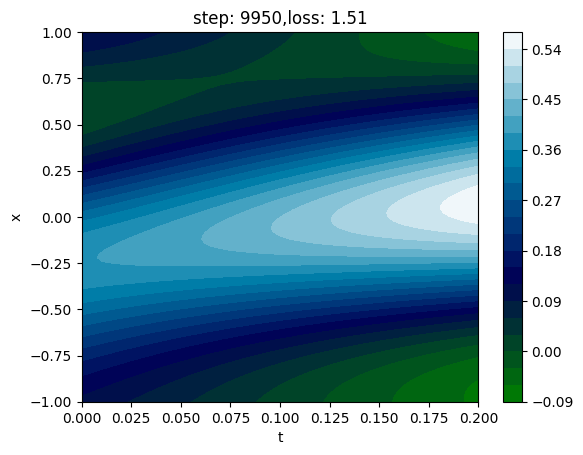

In [20]:
if torch.is_tensor(X_train_Nf) != True:
    # Convert to tensor and send to GPU
    # Initial conditions
    X_train_Ini = torch.from_numpy(X_train_Ini).float().to(device)
    Y_train_Ini = torch.from_numpy(Y_train_Ini).float().to(device)

    # Boundary conditions
    X_train_Bound = torch.from_numpy(X_train_Bound).float().to(device)

    # Collocation points
    X_train_Nf = torch.from_numpy(X_train_Nf).float().to(device)

    # Testing points/FDTD solutions
    X_test = torch.from_numpy(X_test).float().to(device)
    Y_test = torch.from_numpy(Y_test).float().to(device)

    # Gradient zero
    f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)
    p_x_hat = torch.zeros(X_train_Bound.shape[0],1).to(device)

# For plot figure
x1=X_test[:,0]
t1=X_test[:,1]
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()

# 1. Instantiating the model
PINN = FCN(layers)
PINN.to(device)

# 2. Defining two optimizers and training strategy'''
optimizer1 = torch.optim.Adam(PINN.parameters(), lr=lr)
optimizer2 = torch.optim.LBFGS(PINN.parameters(), lr=lr)
# Enable anomaly detection in autograd.
torch.autograd.set_detect_anomaly(True)
# When to switch LBFGS
SwitchStep = int(steps*4/5)

# 3. Training
def closure():
    # 1. Zero out the gradients before the next forward pass
    optimizer2.zero_grad()
    # 2. Calculate the loss and backpropagate it
    loss = PINN.loss(X_train_Bound, X_train_Ini, Y_train_Ini, X_train_Nf)
    loss.backward()
    return loss

# Training steps
for i in range(int(steps)):
    if i == SwitchStep:
        # Switch to L-BFGS optimizer
        optimizer1.zero_grad()
        optimizer2 = optim.LBFGS(PINN.parameters(), lr=lr)

    # 1. Calculate loss
    loss = PINN.loss(X_train_Bound, X_train_Ini, Y_train_Ini, X_train_Nf)
    #losses_PINN_synthetic.append(loss.item())
    losses_PINN_realworld.append(loss.item())

    if i < SwitchStep: # use optimizer 1
        # 2. Clearing the gradients from the previous iteration
        optimizer1.zero_grad()
        # 3. Back propagate the loss
        loss.backward()
        # 4. Updating the model parameters with the calculated gradients
        optimizer1.step()
        # 5. Evaluating the model on the test set and get the predictions
        results = PINN(X_test)

    else: # use optimizer 2
        # 2. Updating the model parameters with L-BFGS
        optimizer2.step(closure = closure)
        # 3. Evaluating the model on the test set and get the predictions
        results = PINN(X_test)

    # Print the loss every 1/200 of the total steps
#     if (i + 1) % int(steps/200) == 0:
#         print(f'Step [{i+1}/{int(steps)}], Loss: {loss.item():.4f}')

    # Plot the results every 1/200 of the total steps
    if i%(steps/200)==0:
        # Reshaping the predictions for visualization
        arr_y1 = results.reshape(shape=X.shape).transpose(1,0).detach().cpu()
        # Visualizing the model's predictions and the true function
        plot3D_Train(arr_x1,arr_T1,arr_y1,i,loss.detach().cpu().numpy())
        # Clearing the previous visualization and display the new one
        display.clear_output(wait=True)
        plt.show()

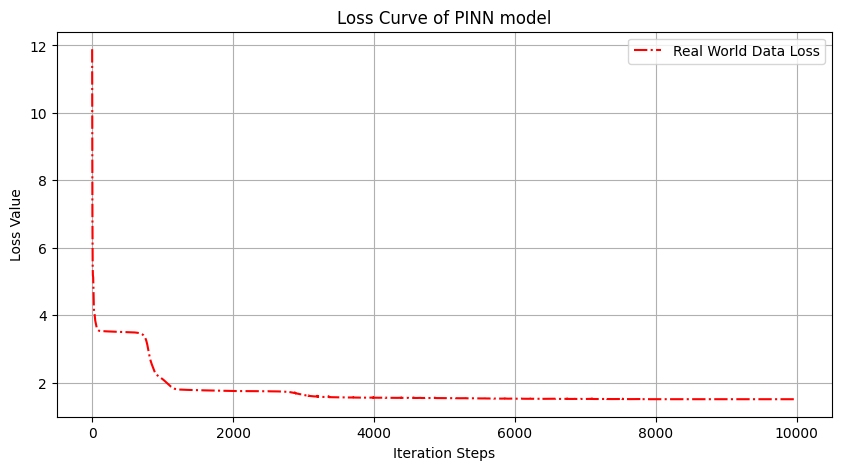

In [21]:
import matplotlib.pyplot as plt

# Plot the loss curves
# To see synthetic data we have to uncomment the losses_PINN_synthetic variable above and run the code again
plt.figure(figsize=(10, 5))
#plt.plot(losses_PINN_synthetic, label='Synthetic Data', color='blue', linestyle='--')
plt.plot(losses_PINN_realworld, label='Real World Data Loss', color='red', linestyle='-.')
plt.xlabel('Iteration Steps')
plt.ylabel('Loss Value')
plt.title('Loss Curve of PINN model')
plt.legend()
plt.grid(True)
plt.show()

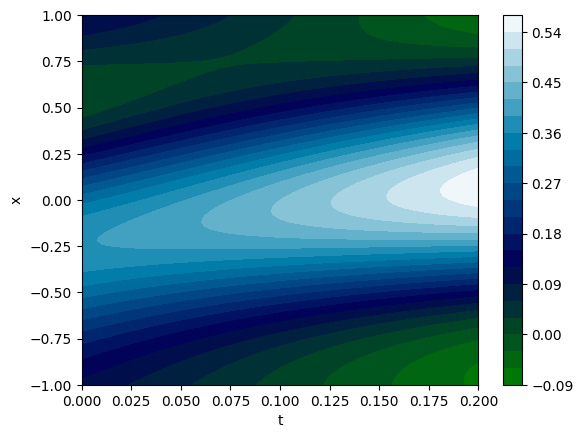

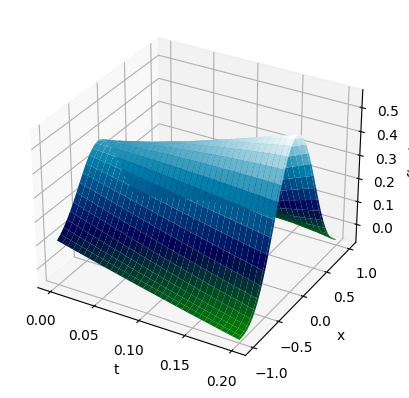

In [22]:
# Plotting the PINN models results
x1=X_test[:,0]
t1=X_test[:,1]
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_y1 = PINN(X_test).reshape(shape=X.shape).transpose(1,0).detach().cpu()
plot3D_Matrix(arr_x1,arr_T1,arr_y1)

<Figure size 640x480 with 0 Axes>

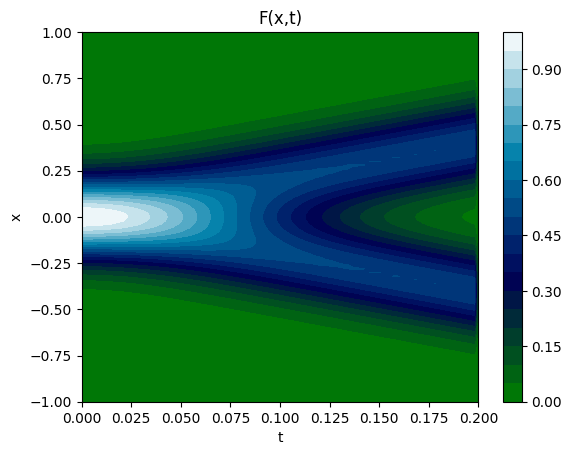

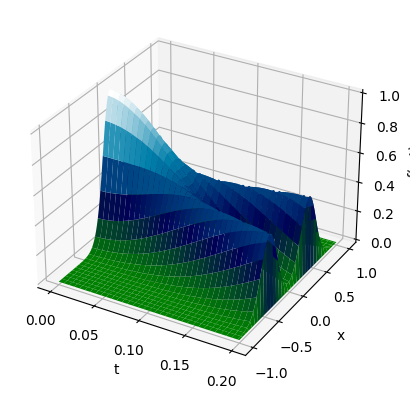

In [23]:
# Plotting the solution using the FDTD method on synthetic empirical data
plt.figure()
plot3D(x_FDTD,t_FDTD,u_FDTD)